# DA for CAE_Linear kol_model.py

In [1]:
import random
from time import perf_counter

import torch
from torch import nn
import torch.nn.functional as F
import numpy
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("svg")


def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    numpy.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = True


def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    numpy.random.seed(worker_seed)
    random.seed(worker_seed)


def set_device():
    """
    Use CPU if cuda device is not available
    setup tf32 for faster GPU computation
    """
    if torch.cuda.device_count() == 0:
        return "cpu"
    torch.set_float32_matmul_precision("high")
    return "cuda"


set_seed(42)
g = torch.Generator()
g.manual_seed(42)
device = set_device()
device

/scratch_dgxl/wy524/miniconda3/envs/irp-env/lib/python3.10/site-packages/torch/cuda/__init__.py:716: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


'cpu'

In [2]:
from kol_model import KOL_C_FORWARD

forward_model = KOL_C_FORWARD()
forward_model.load_state_dict(torch.load('../../../results/CAE_Linear/KMG/jointly_model_weights/forward_model.pt', weights_only=True, map_location=device))
forward_model.eval()

print(forward_model)

KOL_C_FORWARD(
  (K_S): KOL_K_S(
    (input_proj): Conv2d(1, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (downsample): Conv2d(128, 128, kernel_size=(4, 4), stride=(4, 4))
    (factorized_layers): ModuleList(
      (0-1): 2 x FactorizedBlock(
        (attn): FactorizedAttention2D(
          (to_qkv): Linear(in_features=128, out_features=384, bias=False)
          (to_out): Linear(in_features=128, out_features=128, bias=True)
          (rope): RoPE2D()
          (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        )
        (mlp): Sequential(
          (0): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (1): Linear(in_features=128, out_features=256, bias=True)
          (2): GELU(approximate='none')
          (3): Linear(in_features=256, out_features=128, bias=True)
        )
      )
    )
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (final_proj): Linear(in_features=32768, out_features=512, bias=True)
    (dropout): Dropout(p=0.1, 

In [3]:
import os
import sys
current_directory = os.getcwd()
src_directory = os.path.abspath(os.path.join(current_directory, "..", "..", ".."))
sys.path.append(src_directory)

from src.utils.Dataset import KolDynamicsDataset

foward_step = 12

val_idx = 3

cyl_train_dataset = KolDynamicsDataset(data_path="../../../data/kolmogorov/RE450_n4/kolmogorov_train_data.npy",
                seq_length = foward_step,
                mean=None,
                std=None)
    
cyl_val_dataset = KolDynamicsDataset(data_path="../../../data/kolmogorov/RE450_n4/kolmogorov_val_data.npy",
            seq_length = foward_step,
            mean=cyl_train_dataset.mean,
            std=cyl_train_dataset.std)

denorm = cyl_val_dataset.denormalizer()

Loaded Kolmogorov data with shape: (96, 320, 1, 64, 64)
dataset total samples: 29568
Loaded Kolmogorov data with shape: (24, 320, 1, 64, 64)
dataset total samples: 7392


In [4]:
groundtruth = cyl_val_dataset.data[val_idx, ...]
groundtruth = torch.from_numpy(groundtruth)

groundtruth.shape

torch.Size([320, 1, 64, 64])

In [5]:
def visualize_image(image_2d, title='Image', cmap='viridis'):
    if isinstance(image_2d, torch.Tensor):
        image_2d = image_2d.detach().cpu().numpy()

    plt.figure(figsize=(2, 2))
    plt.imshow(image_2d, cmap=cmap)
    plt.colorbar()
    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [6]:
import os
import sys
import numpy as np

class UnifiedDynamicSparseObservationHandler:
    def __init__(self, max_obs_ratio: float = 0.15, min_obs_ratio: float = 0.05, seed: int = 42):
        self.max_obs_ratio = max_obs_ratio
        self.min_obs_ratio = min_obs_ratio
        self.seed = seed
        self.fixed_positions = None
        self.max_obs_count = 0
        self.time_masks = {}
        
        if seed is not None:
            torch.manual_seed(seed)
            np.random.seed(seed)
    
    def generate_unified_observations(self, image_shape: tuple, time_steps: list) -> int:
        if len(image_shape) == 3:
            C, H, W = image_shape
        else:
            raise ValueError(f"Expected 3D image shape (C, H, W), got {image_shape}")
        
        total_pixels = C * H * W
        self.max_obs_count = int(total_pixels * self.max_obs_ratio)
        
        self.fixed_positions = torch.randperm(total_pixels)[:self.max_obs_count]
        print(f"Fixed observation positions generated: {self.max_obs_count} positions")
        
        for i, t in enumerate(time_steps):
            obs_ratio = np.random.uniform(self.min_obs_ratio, self.max_obs_ratio)
            num_valid = int(total_pixels * obs_ratio)
            num_valid = min(num_valid, self.max_obs_count)
            
            valid_indices = torch.randperm(self.max_obs_count)[:num_valid]
            
            self.time_masks[i] = {
                'num_valid': num_valid,
                'valid_indices': valid_indices,
                'obs_ratio': obs_ratio
            }
            
            print(f"Time step {t}: {num_valid}/{self.max_obs_count} observations ({obs_ratio:.3f} ratio)")
        
        return self.max_obs_count
    
    def apply_unified_observation(self, full_image: torch.Tensor, time_step_idx: int) -> torch.Tensor:
        if time_step_idx not in self.time_masks:
            raise ValueError(f"Time step index {time_step_idx} not found in masks")
        
        mask_info = self.time_masks[time_step_idx]
        
        flat_image = full_image.flatten()
        fixed_obs = flat_image[self.fixed_positions]
        
        obs_vector = torch.zeros(self.max_obs_count, device=full_image.device)
        valid_indices = mask_info['valid_indices']
        obs_vector[valid_indices] = fixed_obs[valid_indices]
        
        return obs_vector
    
    def create_block_R_matrix(self, base_variance=1e-3):
        R = torch.eye(self.max_obs_count) * base_variance
        return R
    
    def create_unified_R_matrix(self, base_variance: float = 1e-3, 
                               invalid_variance: float = 1.0) -> torch.Tensor:
        R = torch.eye(self.max_obs_count) * invalid_variance
        
        min_valid = min(mask_info['num_valid'] for mask_info in self.time_masks.values())
        
        R[:min_valid, :min_valid] = torch.eye(min_valid) * base_variance
        
        return R

In [7]:
_global_obs_handler = None
_global_time_idx = 0

def update_observation_time_index(time_idx: int):
    global _global_time_idx
    _global_time_idx = time_idx

### DA

In [8]:
import torchda

In [9]:
obs_handler = UnifiedDynamicSparseObservationHandler(
    max_obs_ratio=0.11, 
    min_obs_ratio=0.09, 
    seed=42
)

In [10]:
start_da_end_idxs = (155, 160, 175)

time_obs = [
    start_da_end_idxs[1],
    start_da_end_idxs[1] + 2,
    start_da_end_idxs[1] + 4,
]
gaps = [2] * (len(time_obs) - 1)

full_y_data = [
    cyl_val_dataset.normalize(groundtruth[i+1, ...])
    for i in range(groundtruth.shape[0])
    if i in time_obs
]

full_y_data = torch.cat(full_y_data).to(device)

In [11]:
print(full_y_data.shape)

torch.Size([3, 1, 64, 64])


In [12]:
sample_image_shape = full_y_data[0].shape
max_obs_count = obs_handler.generate_unified_observations(sample_image_shape, range(len(time_obs)))

sparse_y_data = []
for i, full_img in enumerate(full_y_data):
    sparse_obs = obs_handler.apply_unified_observation(full_img, i)
    sparse_y_data.append(sparse_obs)
sparse_y_data = torch.stack(sparse_y_data).to(device)

print(f"Original observation shape: {full_y_data.shape}")
print(f"Dynamic sparse observation shape: {sparse_y_data.shape}")

Fixed observation positions generated: 450 positions
Time step 0: 399/450 observations (0.097 ratio)
Time step 1: 446/450 observations (0.109 ratio)
Time step 2: 428/450 observations (0.105 ratio)
Original observation shape: torch.Size([3, 1, 64, 64])
Dynamic sparse observation shape: torch.Size([3, 450])


In [13]:
def H_unified(x):
    global _global_time_idx, _global_obs_handler
    
    x_reconstructed = forward_model.K_S_preimage(x)
    sparse_obs = _global_obs_handler.apply_unified_observation(
        x_reconstructed.squeeze(), _global_time_idx
    )
    return sparse_obs.unsqueeze(0)

_global_obs_handler = obs_handler

In [14]:
_global_obs_handler = obs_handler

In [15]:
latent_dim = int(forward_model.C_forward.in_features)
B = torch.eye(latent_dim, device=device)

R = obs_handler.create_block_R_matrix(base_variance=1e-3).to(device)

obs_dim = sparse_y_data.shape[1]

print(f"Background covariance B shape: {B.shape}")
print(f"Observation dimension: {obs_dim}")

print(f"R matrix shape: {R.shape}")
print(f"R matrix condition number: {torch.linalg.cond(R):.2e}")
print(f"R matrix rank: {torch.linalg.matrix_rank(R)}")
print(f"R matrix is invertible: {torch.linalg.matrix_rank(R) == R.shape[0]}")

Background covariance B shape: torch.Size([512, 512])
Observation dimension: 450
R matrix shape: torch.Size([450, 450])
R matrix condition number: 1.00e+00
R matrix rank: 450
R matrix is invertible: True


In [16]:
def dmd_warpper(z_t, time_fw=None, *args):
    if time_fw == None:
        if z_t.ndim == 1:
            z_t = z_t.unsqueeze(0)

        z_tp = forward_model.latent_forward(z_t)
        
    else:
        if z_t.ndim == 1:
            z_t = z_t.unsqueeze(0)

        z_tp = torch.empty((time_fw.shape[0], z_t.shape[0], z_t.shape[1]), device=z_t.device)
        
        current_state = forward_model.K_S_preimage(z_t)
        
        for i in range(int(time_fw.shape[0])):
            z_current = forward_model.K_S(current_state)
            z_tp[i] = z_current
            
            if i < int(time_fw.shape[0]) - 1:
                z_next = forward_model.latent_forward(z_current)
                current_state = forward_model.K_S_preimage(z_next)
    
    return z_tp

In [17]:
case_to_run = (
    torchda.CaseBuilder()
    .set_observation_time_steps(time_obs)
    .set_gaps(gaps)
    .set_forward_model(dmd_warpper)
    .set_observation_model(H_unified)
    .set_background_covariance_matrix(B)
    .set_observation_covariance_matrix(R)
    .set_observations(sparse_y_data)
    .set_optimizer_cls(torch.optim.Adam)
    .set_optimizer_args({"lr": 0.01})
    .set_max_iterations(1000)
    .set_algorithm(torchda.Algorithms.Var4D)
    .set_device(torchda.Device.CPU)
    .set_output_sequence_length(1)
)

In [18]:
outs_4d_da = []

start_time = perf_counter()

current_state = cyl_val_dataset.normalize(groundtruth[start_da_end_idxs[0]])

for i in range(start_da_end_idxs[0], start_da_end_idxs[-1] + 1):
    print(f"Processing step {i}")
    
    z_current = forward_model.K_S(current_state)
    
    if i == start_da_end_idxs[1]:
        update_observation_time_index(0)
        
        case_to_run.set_background_state(z_current.ravel())
        result = case_to_run.execute()
        z_assimilated = result["assimilated_state"]
        
        intermediate_results = result["intermediate_results"]
        final_cost = intermediate_results["J"][-1]
        print(f"Final cost function: {final_cost}")
        print(f"Number of iterations: {len(intermediate_results['J'])}")
        
        outs_4d_da.append(z_assimilated)
        
        current_state = forward_model.K_S_preimage(z_assimilated)
    else:
        outs_4d_da.append(z_current)
        
        z_next = dmd_warpper(z_current)
        current_state = forward_model.K_S_preimage(z_next)
    
    print("=" * 50)

print(f"Unified dynamic sparse observation 4D-Var time: {perf_counter() - start_time}s")

Processing step 155
Processing step 156
Processing step 157
Processing step 158
Processing step 159
Processing step 160
Timestamp: 2025-07-17 22:21:19.479654, Iterations: 0, Jb: 0.0, Jo: 657439.25, J: 657439.25, Norm of J gradient: 43871.75390625
Timestamp: 2025-07-17 22:21:20.137868, Iterations: 1, Jb: 0.051199715584516525, Jo: 649512.1875, J: 649512.25, Norm of J gradient: 43682.9765625
Timestamp: 2025-07-17 22:21:20.798546, Iterations: 2, Jb: 0.2032645046710968, Jo: 641613.5, J: 641613.6875, Norm of J gradient: 43501.2109375
Timestamp: 2025-07-17 22:21:21.598584, Iterations: 3, Jb: 0.45579370856285095, Jo: 633748.375, J: 633748.8125, Norm of J gradient: 43315.33984375
Timestamp: 2025-07-17 22:21:22.274097, Iterations: 4, Jb: 0.8075734972953796, Jo: 625921.0, J: 625921.8125, Norm of J gradient: 43119.70703125
Timestamp: 2025-07-17 22:21:22.964665, Iterations: 5, Jb: 1.256978988647461, Jo: 618137.25, J: 618138.5, Norm of J gradient: 42907.390625
Timestamp: 2025-07-17 22:21:23.642141, 

In [19]:
outs_no_4d_da = []
start_time = perf_counter()
with torch.no_grad():
    current_state = cyl_val_dataset.normalize(groundtruth[start_da_end_idxs[0]])
    
    for i in range(start_da_end_idxs[0], start_da_end_idxs[-1] + 1):
        print(i)
        
        z_current = forward_model.K_S(current_state)
        
        outs_no_4d_da.append(z_current)
        
        z_next = forward_model.latent_forward(z_current)
        next_state = forward_model.K_S_preimage(z_next)
        
        current_state = next_state
        print("===============================")
print(f"time elapse for pure dmd: {perf_counter() - start_time}s")

155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
time elapse for pure dmd: 0.3018711330369115s


In [20]:
real_img = groundtruth

len(outs_4d_da), len(outs_no_4d_da), real_img.shape

(21, 21, torch.Size([320, 1, 64, 64]))

In [21]:
# diffs = []
diffs_da_real_mse = []
diffs_noda_real_mse = []
diffs_da_real_rrmse = []
diffs_noda_real_rrmse = []
diffs_da_real_ssim = []
diffs_noda_real_ssim = []

with torch.no_grad():
    for i, (no_da, da) in enumerate(zip(outs_no_4d_da, outs_4d_da), start=start_da_end_idxs[0]):
        
        da_img = forward_model.K_S_preimage(da).view(1, 64, 64)
        noda_img = forward_model.K_S_preimage(no_da).view(1, 64, 64)

        de_da_img = denorm(da_img)
        de_noda_img = denorm(noda_img)
        
        da_minus_real_img_square = (de_da_img[0] - real_img[i]) ** 2
        noda_minus_real_img_square = (de_noda_img[0] - real_img[i]) ** 2

        diffs_da_real_mse.append(da_minus_real_img_square.mean())
        diffs_noda_real_mse.append(noda_minus_real_img_square.mean())

        diffs_da_real_rrmse.append((da_minus_real_img_square.sum()/((real_img[i]**2).sum())).sqrt())
        diffs_noda_real_rrmse.append((noda_minus_real_img_square.sum()/((real_img[i]**2).sum())).sqrt())

        diffs_da_real_ssim.append(ssim(real_img[i].numpy(), de_da_img[0].numpy(), data_range=1, channel_axis=0))
        diffs_noda_real_ssim.append(ssim(real_img[i].numpy(), de_noda_img[0].numpy(), data_range=1, channel_axis=0))

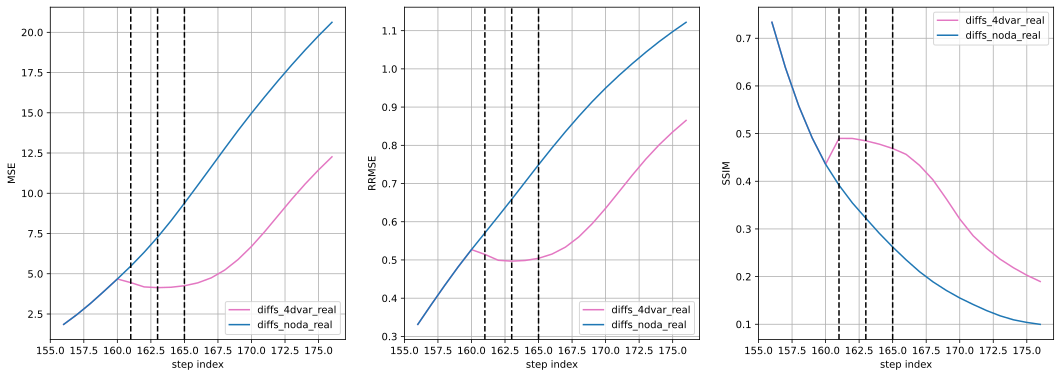

diffs_noda_real_mse[da_idxs[0]]=tensor(6.3345), diffs_noda_real_mse[da_idxs[1]]=tensor(8.2913), diffs_noda_real_mse[da_idxs[2]]=tensor(10.5040)
diffs_da_real_mse[da_idxs[0]]=tensor(4.1815), diffs_da_real_mse[da_idxs[1]]=tensor(4.1610), diffs_da_real_mse[da_idxs[2]]=tensor(4.4349)
diffs_noda_real_rrmse[da_idxs[0]]=tensor(0.6144), diffs_noda_real_rrmse[da_idxs[1]]=tensor(0.7039), diffs_noda_real_rrmse[da_idxs[2]]=tensor(0.7931)
diffs_da_real_rrmse[da_idxs[0]]=tensor(0.4992), diffs_da_real_rrmse[da_idxs[1]]=tensor(0.4986), diffs_da_real_rrmse[da_idxs[2]]=tensor(0.5153)
diffs_noda_real_ssim[da_idxs[0]]=np.float32(0.35442638), diffs_noda_real_ssim[da_idxs[1]]=np.float32(0.29094782), diffs_noda_real_ssim[da_idxs[2]]=np.float32(0.23518288)
diffs_da_real_ssim[da_idxs[0]]=np.float32(0.489805), diffs_da_real_ssim[da_idxs[1]]=np.float32(0.47784925), diffs_da_real_ssim[da_idxs[2]]=np.float32(0.4564689)


In [22]:
step_idxs = list(range(start_da_end_idxs[0] + 1, start_da_end_idxs[-1] + 2))

_, ax = plt.subplots(1, 3, figsize=(18, 6))

ax[0].plot(step_idxs, diffs_da_real_mse, color="#e377c2", label="diffs_4dvar_real")
ax[0].plot(step_idxs, diffs_noda_real_mse, color="#1f77b4", label="diffs_noda_real")

ax[1].plot(step_idxs, diffs_da_real_rrmse, color="#e377c2", label="diffs_4dvar_real")
ax[1].plot(step_idxs, diffs_noda_real_rrmse, color="#1f77b4", label="diffs_noda_real")

ax[2].plot(step_idxs, diffs_da_real_ssim, color="#e377c2", label="diffs_4dvar_real")
ax[2].plot(step_idxs, diffs_noda_real_ssim, color="#1f77b4", label="diffs_noda_real")

for i, name in enumerate(["MSE", "RRMSE", "SSIM"]):
    ax[i].set_xlabel("step index")
    ax[i].set_ylabel(name)
    ax[i].grid(True)
    ax[i].legend()
    for x in time_obs:
        ax[i].axvline(x=x+1, color="k", linestyle="--")

plt.show()

da_idxs = [6, 8, 10]
print(f"{diffs_noda_real_mse[da_idxs[0]]=}, {diffs_noda_real_mse[da_idxs[1]]=}, {diffs_noda_real_mse[da_idxs[2]]=}")
print(f"{diffs_da_real_mse[da_idxs[0]]=}, {diffs_da_real_mse[da_idxs[1]]=}, {diffs_da_real_mse[da_idxs[2]]=}")
print(f"{diffs_noda_real_rrmse[da_idxs[0]]=}, {diffs_noda_real_rrmse[da_idxs[1]]=}, {diffs_noda_real_rrmse[da_idxs[2]]=}")
print(f"{diffs_da_real_rrmse[da_idxs[0]]=}, {diffs_da_real_rrmse[da_idxs[1]]=}, {diffs_da_real_rrmse[da_idxs[2]]=}")
print(f"{diffs_noda_real_ssim[da_idxs[0]]=}, {diffs_noda_real_ssim[da_idxs[1]]=}, {diffs_noda_real_ssim[da_idxs[2]]=}")
print(f"{diffs_da_real_ssim[da_idxs[0]]=}, {diffs_da_real_ssim[da_idxs[1]]=}, {diffs_da_real_ssim[da_idxs[2]]=}")

160
8184.583
6294.044
162
9192.678
6378.5713
164
10375.814
6638.1724


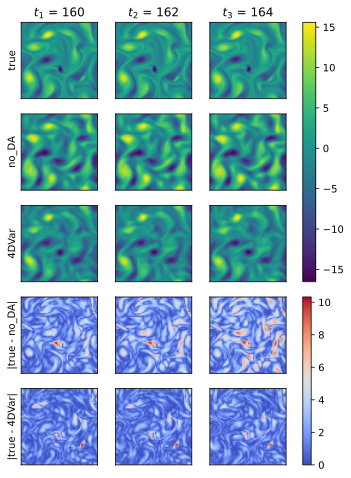

In [23]:
fig, ax = plt.subplots(5, len(da_idxs), figsize=(2 * len(da_idxs), 8), sharex=True)
for x in ax.flat:
    x.set_xticks([])
    x.set_yticks([])
    x.set_xticklabels([])
    x.set_yticklabels([])

setup_cmap = True
with torch.no_grad():
    for i, da_idx in enumerate(da_idxs):
        if i == 0:
            img_tensor = real_img[time_obs[i]+1, 0, ...]
        else:
            img_tensor = real_img[time_obs[i], 0, ...]
        print(time_obs[i])
        im1 = ax[0, i].imshow(torch.reshape(img_tensor, (64, 64)), cmap="viridis")
        if setup_cmap:
            # Create a ScalarMappable object with the colormap from images
            sm1 = plt.cm.ScalarMappable(cmap=im1.cmap, norm=im1.norm)
        no_da = forward_model.K_S_preimage(outs_no_4d_da[da_idx]).cpu()
        da = forward_model.K_S_preimage(outs_4d_da[da_idx]).cpu()

        de_no_da = denorm(no_da)
        de_da = denorm(da)

        image_noda = de_no_da[0, 0, ...]
        image_da = de_da[0, 0, ...]
        
        print(np.sum(np.abs(img_tensor.numpy() - image_noda.numpy())))
        print(np.sum(np.abs(img_tensor.numpy() - image_da.numpy())))

        ax[1, i].imshow(torch.reshape(image_noda, (64, 64)), cmap="viridis")
        ax[2, i].imshow(torch.reshape(image_da, (64, 64)), cmap="viridis")
        res = (img_tensor.reshape((64, 64)) - image_noda.reshape((64, 64))).abs()
        res = torch.where(res > 0.1, res, 0)
        im2 = ax[3, i].imshow(res, cmap="coolwarm")
        if setup_cmap:
            sm2 = plt.cm.ScalarMappable(cmap=im2.cmap, norm=im2.norm)
        res = (img_tensor.reshape((64, 64)) - image_da.reshape((64, 64))).abs()
        res = torch.where(res > 0.1, res, 0)
        ax[4, i].imshow(res, cmap="coolwarm")
        setup_cmap = False

for i, title in enumerate([f"$t_1$ = {time_obs[0]}", f"$t_2$ = {time_obs[1]}", f"$t_3$ = {time_obs[2]}"]):
    ax[0, i].set_title(title)
# ax[0].set_title("$t$")
for i, ylabel in enumerate(["true", "no_DA", "4DVar", "|true - no_DA|", "|true - 4DVar|"]):
    ax[i, 0].set_ylabel(ylabel)

# # Create a ScalarMappable object with the colormap from images
# sm1 = plt.cm.ScalarMappable(cmap=im1.cmap, norm=im1.norm)

# Remove the set_array to avoid warning
sm1.set_array([])

# Add a colorbar to the figure that uses the ScalarMappable
# fig.colorbar(sm1, ax=ax, orientation="vertical")

fig.colorbar(sm1, ax=ax[:-2, :], orientation="vertical")
sm2 = plt.cm.ScalarMappable(cmap=im2.cmap, norm=im2.norm)
sm2.set_array([])
fig.colorbar(sm2, ax=ax[-2:, :], orientation="vertical")

plt.show()